# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract, get_public_holidays
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [3]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# # 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)
csv_dataframes

{'olist_customers':                             customer_id                customer_unique_id  \
 0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 ...                                 ...                               ...   
 99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
 99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
 99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
 99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
 99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   
 
        customer_zip_code_prefix          c

### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [4]:
load(data_frames=csv_dataframes, database=ENGINE)

table: olist_customers, rows: customer_id                 99441
customer_unique_id          99441
customer_zip_code_prefix    99441
customer_city               99441
customer_state              99441
dtype: int64
table: olist_geolocation, rows: geolocation_zip_code_prefix    1000163
geolocation_lat                1000163
geolocation_lng                1000163
geolocation_city               1000163
geolocation_state              1000163
dtype: int64
table: olist_order_items, rows: order_id               112650
order_item_id          112650
product_id             112650
seller_id              112650
shipping_limit_date    112650
price                  112650
freight_value          112650
dtype: int64
table: olist_order_payments, rows: order_id                103886
payment_sequential      103886
payment_type            103886
payment_installments    103886
payment_value           103886
dtype: int64
table: olist_order_reviews, rows: review_id                  99224
order_id              

##### 3.1 Queries sobre ingresos

In [5]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

In [6]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,137006.76,1102639.41
1,02,Feb,0.00,283621.94,979966.23
2,03,Mar,0.00,425656.40,1152736.74
3,04,Apr,0.00,405988.38,1156303.91
4,05,May,0.00,582926.16,1145748.63
5,06,Jun,0.00,499827.47,1020494.29
6,07,Jul,0.00,578858.58,1039880.16
7,08,Aug,0.00,662071.77,996896.15
8,09,Sep,136.23,717195.22,166.46
9,10,Oct,51657.53,764785.28,0.00


In [7]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,9272,1692714.28
1,health_beauty,8646,1620684.04
2,computers_accessories,6529,1549252.47
3,furniture_decor,6307,1394466.93
4,watches_gifts,5493,1387046.31
5,sports_leisure,7529,1349252.93
6,housewares,5743,1069787.97
7,auto,3809,833610.84
8,garden_tools,3448,810614.93
9,cool_stuff,3559,744649.32


In [8]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,12,1199.43
3,home_comfort_2,24,1710.54
4,flowers,29,2213.01
5,arts_and_craftmanship,23,2326.17
6,la_cuisine,13,2913.53
7,fashion_sport,26,3605.83
8,diapers_and_hygiene,25,4126.17
9,fashio_female_clothing,36,4902.67


In [9]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


##### 3.2 Queries sobre entregas

In [10]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [11]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.647044,14.080563,NaN,39.508831,26.302555
1,02,Feb,NaN,13.168825,16.945138,NaN,31.848929,24.528996
2,03,Mar,NaN,12.951184,16.301410,NaN,24.732386,22.033067
3,04,Apr,NaN,14.917913,11.499241,NaN,27.349810,23.679546
4,05,May,NaN,11.322363,11.419029,NaN,24.284784,22.891488
5,06,Jun,NaN,12.011573,9.239216,NaN,24.021864,27.772740
6,07,Jul,NaN,11.592732,8.958636,NaN,23.317316,19.690127
7,08,Aug,NaN,11.147125,7.732780,NaN,23.480603,15.186330
8,09,Sep,54.813194,11.851007,NaN,18.488449,22.437366,NaN
9,10,Oct,19.600559,11.856700,NaN,55.676632,23.019536,NaN


In [12]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [13]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,date,order_count,holiday
0,2017-01-05,32,False
1,2017-01-06,4,False
2,2017-01-07,4,False
3,2017-01-08,6,False
4,2017-01-09,5,False
...,...,...,...
356,2017-12-27,167,False
357,2017-12-28,146,False
358,2017-12-29,135,False
359,2017-12-30,97,False


In [14]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

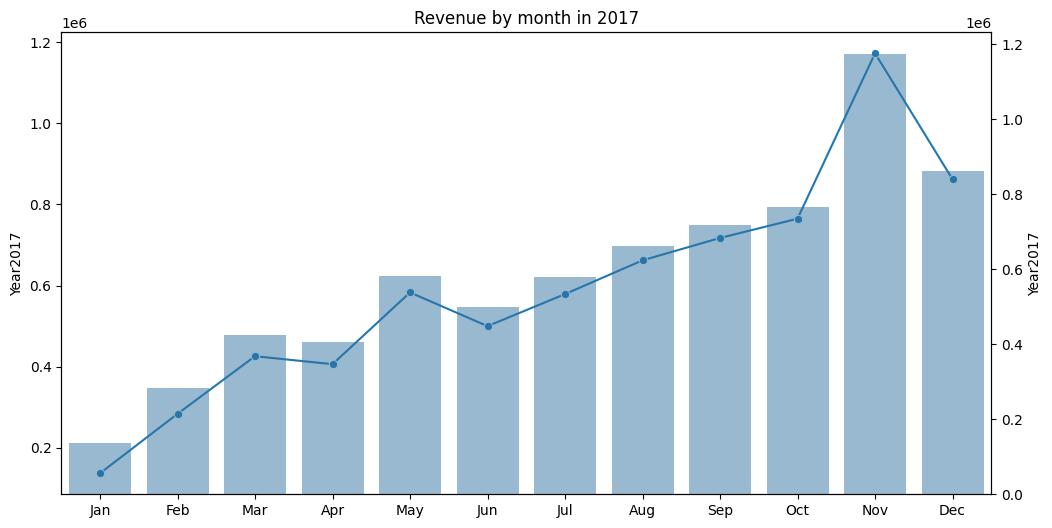

In [15]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [16]:
plot_top_10_revenue_categories(top_10_revenue_categories)

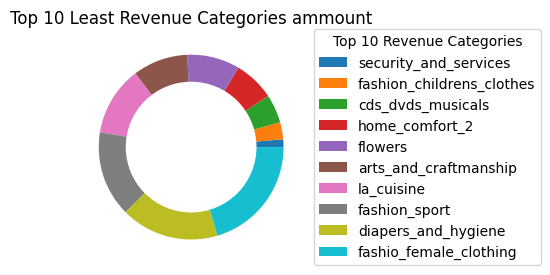

In [17]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [18]:
plot_revenue_per_state(revenue_per_state)

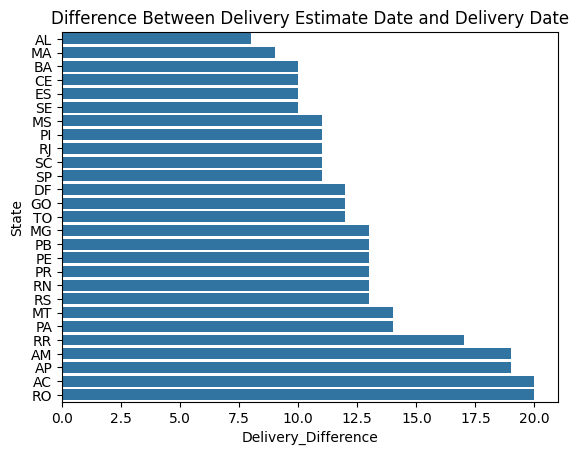

In [19]:
plot_delivery_date_difference(delivery_date_difference)

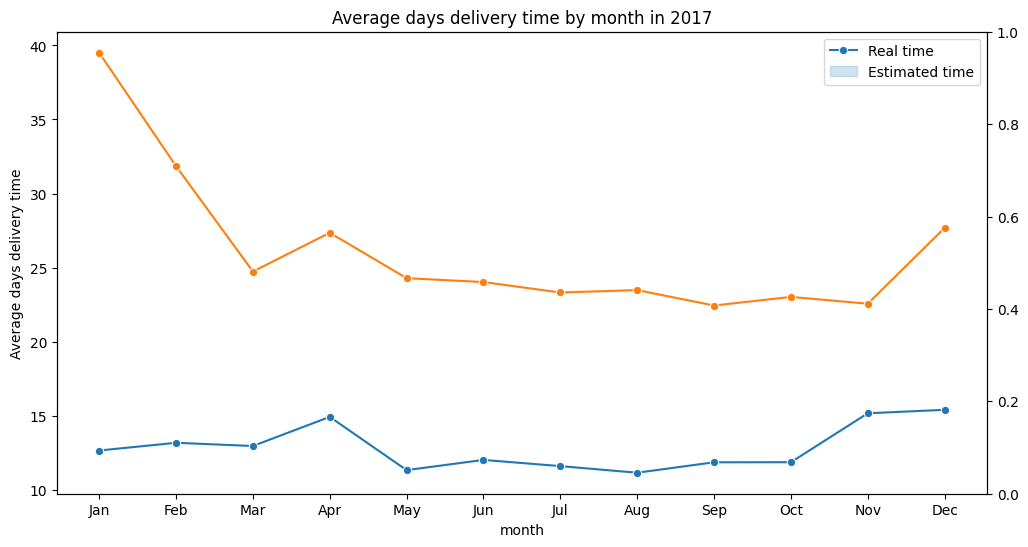

In [20]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

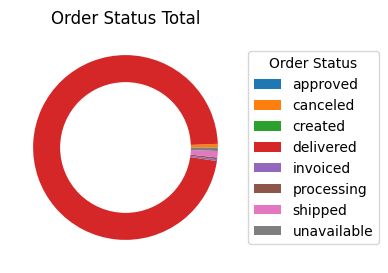

In [21]:
plot_global_amount_order_status(global_ammount_order_status)

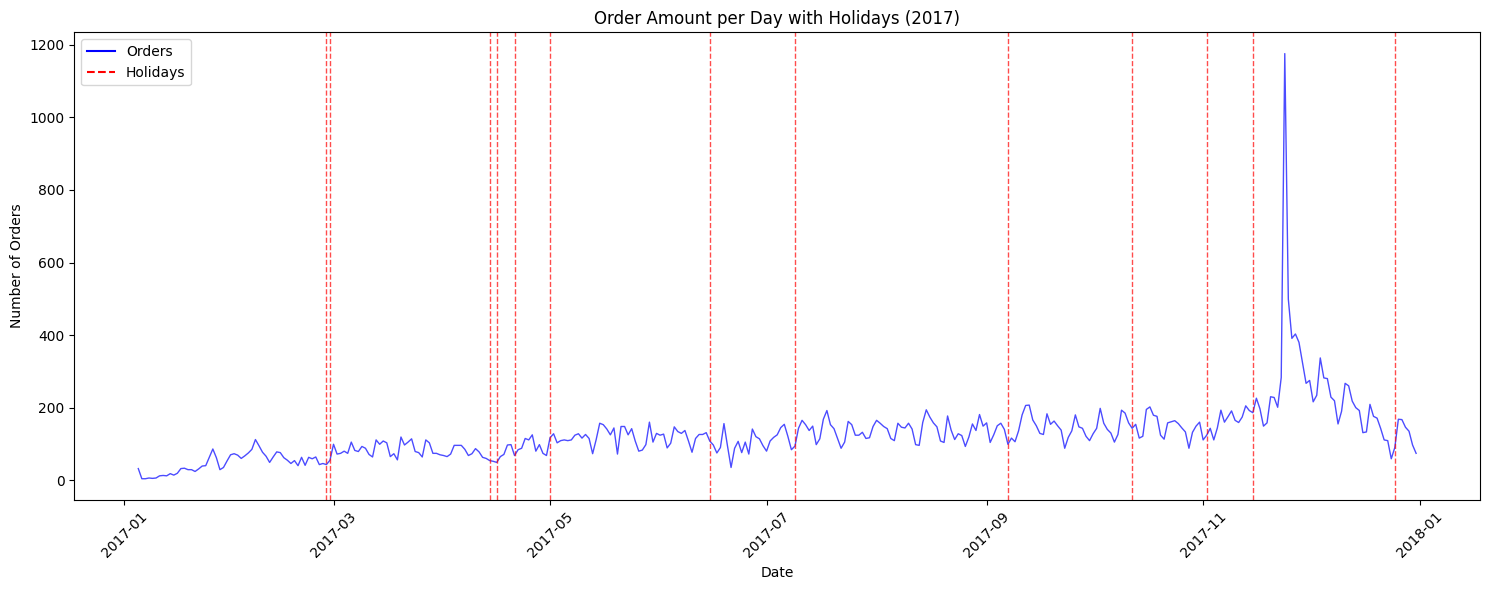

In [22]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta:

- Durante la mayor parte del año (enero a octubre), las compras se mantienen en niveles relativamente estables y bajos (generalmente entre 50-200 unidades)
- Los días festivos no parecen generar picos significativos de compras durante estos meses
- A partir de noviembre, hay un incremento dramático en las compras, alcanzando el pico máximo cerca de 1,200 unidades en diciembre


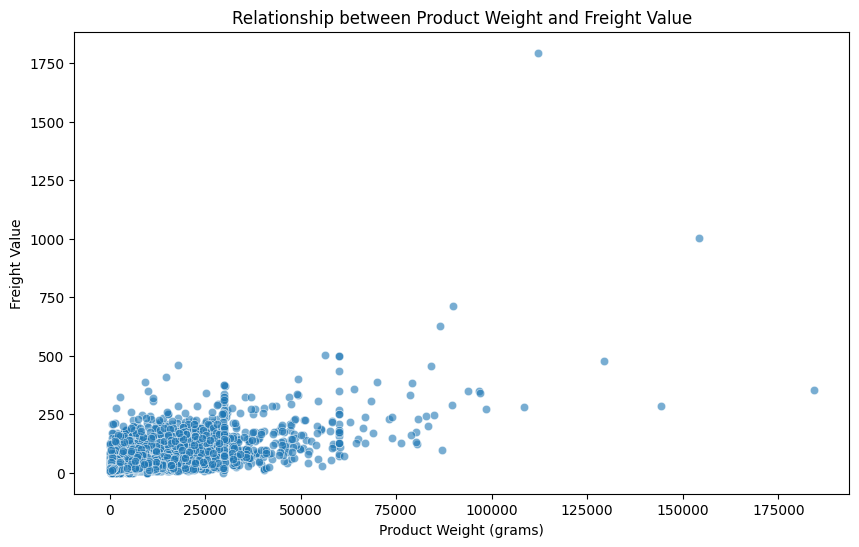

In [23]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta:
- Aunque existe correlación positiva entre peso y valor del flete, el peso solo explica parcialmente el costo. Otros factores como destino, tipo de producto, urgencia de entrega, o políticas de precios específicas probablemente también influyen considerablemente en el valor final del flete.